In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

# 1️ Load Real Dataset (we use sklearn only for loading)
data = fetch_california_housing(as_frame=True)
X = data.data.values
y = data.target.values.reshape(-1, 1)  # shape (20640, 1)

print("Dataset shape:", X.shape)
print("Feature names:", list(data.feature_names))


Dataset shape: (20640, 8)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [4]:
# 2️. Manual helper functions

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def standardize(X):
    """Standardize features to zero mean, unit variance."""
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-12
    return (X - mean) / std

# Standardize the dataset
X = standardize(X)


In [5]:
# 3️. Manual Linear Regression implementation

class ManualLinearRegression:
    def __init__(self):
        self.theta = None  # model coefficients (including intercept)

    def fit(self, X, y):
        # Add bias term (column of ones)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        # θ = (XᵀX)^(-1) Xᵀy
        self.theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.theta)


In [6]:
# 4️. Manual random split (80% train, 20% test)
np.random.seed(42)
n_samples = X.shape[0]
indices = np.random.permutation(n_samples)
split = int(0.8 * n_samples)

train_idx, test_idx = indices[:split], indices[split:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


In [7]:
# 5️ Fit model and evaluate metrics manually

model = ManualLinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_mse = mse(y_train, y_pred_train)
test_mse = mse(y_test, y_pred_test)
train_rmse = rmse(y_train, y_pred_train)
test_rmse = rmse(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("📊 Model Evaluation:")
print(f"Train MSE:  {train_mse:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
print(f"Test  MSE:  {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")


📊 Model Evaluation:
Train MSE:  0.5173, RMSE: 0.7192, R²: 0.6105
Test  MSE:  0.5552, RMSE: 0.7451, R²: 0.5875


In [8]:
# 6️ Manual K-Fold Cross-Validation (no sklearn)

def k_fold_cross_validation(X, y, k=5):
    n = len(X)
    fold_size = n // k
    indices = np.arange(n)
    np.random.shuffle(indices)

    mse_scores, rmse_scores, r2_scores = [], [], []

    for i in range(k):
        # Define validation and training indices
        start = i * fold_size
        end = start + fold_size if i < k - 1 else n
        val_idx = indices[start:end]
        train_idx = np.concatenate((indices[:start], indices[end:]))

        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = ManualLinearRegression()
        model.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)

        mse_scores.append(mse(y_val, y_pred_val))
        rmse_scores.append(rmse(y_val, y_pred_val))
        r2_scores.append(r2_score(y_val, y_pred_val))

    return np.mean(mse_scores), np.mean(rmse_scores), np.mean(r2_scores)

# Perform 5-Fold CV
cv_mse, cv_rmse, cv_r2 = k_fold_cross_validation(X, y, k=5)

print("\n📈 5-Fold Cross-Validation Results (Manual):")
print(f"Avg MSE:  {cv_mse:.4f}")
print(f"Avg RMSE: {cv_rmse:.4f}")
print(f"Avg R²:   {cv_r2:.4f}")



📈 5-Fold Cross-Validation Results (Manual):
Avg MSE:  2.1034
Avg RMSE: 1.1635
Avg R²:   -0.6029


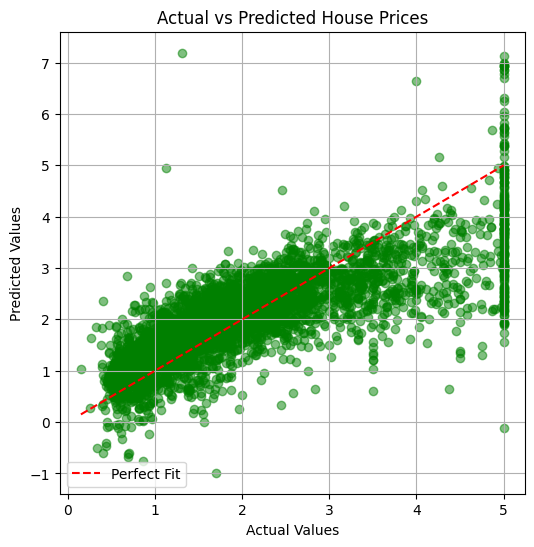

✅ Interpretation:
- MSE and RMSE measure average squared prediction errors (lower is better).
- R² shows how much variance is explained by the model (closer to 1 is better).
- Cross-validation confirms generalization: if CV metrics ≈ test metrics → model is stable.


In [9]:
# 7️ Visualize Actual vs Predicted for Test Set
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()

print("✅ Interpretation:")
print("- MSE and RMSE measure average squared prediction errors (lower is better).")
print("- R² shows how much variance is explained by the model (closer to 1 is better).")
print("- Cross-validation confirms generalization: if CV metrics ≈ test metrics → model is stable.")
